# **PyTorch Experimental Setup**

## **Getting Setup**

### **Imports**

In [28]:
# Regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install torchinfo --quiet
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

### **Device Agnostic Setting**

In [29]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### **Helper Function**

In [30]:
# Helper function to set seed
def set_seeds(seed: int = 42):
    # Set the seed for general torch operations
    torch.manual_seed(seed)

    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

## **Get Data**

In [31]:
# Improts
import os
import zipfile

from pathlib import Path

import requests

# Function to download the data
def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    # Return the image path
    return image_path

# Download and extract the images
image_path = download_data(
    source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination = "pizza_steak_sushi"
)

# View the image path
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

## **Create Datasets and DataLoaders**

### **Manual Transforms**

In [32]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms, # use manually created transforms
    batch_size = 32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7a94443e7ee0>,
 ['pizza', 'steak', 'sushi'])

### **Automatic Transforms**

In [33]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms()
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = automatic_transforms, # use automatic created transforms
    batch_size = 32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7a94443b9870>,
 ['pizza', 'steak', 'sushi'])

## **Pre-Trained Model**

### **Load Model and Model Weights**

In [34]:
# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights = weights).to(device)

# View the output of the model
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### **Freeze Base Model**

In [35]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False

In [36]:
# Set the seed
set_seeds()

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(
        in_features = 1280,
        out_features = len(class_names),
        bias = True
    ).to(device)
)

In [37]:
# Import pytorch summary
from torchinfo import summary

# Get a summary of the model (uncomment for full output)
summary(
    model,
    input_size = (32, 3, 224, 224),
    verbose = 0,
    col_names = ["input_size", "output_size", "num_params", "trainable"],
    col_width = 20,
    row_settings = ["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## **Model Training and Tracking**

### **Loss and Optimizer**

In [38]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [39]:
# Import summary writer for model tracking
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

In [40]:
# Imports
from tqdm.auto import tqdm

from going_modular.going_modular.engine import train_step, test_step

# Import train() function from:
# https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> dict[str, list]:
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        # Training and testing loop
        train_loss, train_acc = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer = optimizer,
                                           device = device)

        test_loss, test_acc = test_step(model = model,
                                        dataloader = test_dataloader,
                                        loss_fn = loss_fn,
                                        device = device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(
            main_tag = "Loss",
            tag_scalar_dict = {
                "train_loss": train_loss,
                "test_loss": test_loss
            },
            global_step=epoch
        )

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy",
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc},
                           global_step=epoch)

        # Track the PyTorch model architecture
        writer.add_graph(model=model,
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))

    # Close the writer
    writer.close()

    ### End ###

    # Return the filled results at the end of the epochs
    return results

In [41]:
# Train model
set_seeds()
results = train(
    model = model,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = 10,
    device = device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8966 | train_acc: 0.6562 | test_loss: 0.7839 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.8045 | train_acc: 0.7422 | test_loss: 0.6716 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6787 | train_acc: 0.7305 | test_loss: 0.6697 | test_acc: 0.8258
Epoch: 5 | train_loss: 0.7066 | train_acc: 0.7188 | test_loss: 0.6737 | test_acc: 0.7737
Epoch: 6 | train_loss: 0.5959 | train_acc: 0.7578 | test_loss: 0.5906 | test_acc: 0.8655
Epoch: 7 | train_loss: 0.5401 | train_acc: 0.9297 | test_loss: 0.5376 | test_acc: 0.8561
Epoch: 8 | train_loss: 0.5476 | train_acc: 0.8047 | test_loss: 0.5318 | test_acc: 0.8561
Epoch: 9 | train_loss: 0.4824 | train_acc: 0.8164 | test_loss: 0.5173 | test_acc: 0.8665
Epoch: 10 | train_loss: 0.4159 | train_acc: 0.9492 | test_loss: 0.4510 | test_acc: 0.8968


In [42]:
# Check out the model results
results

{'train_loss': [1.092943362891674,
  0.896570198237896,
  0.8045311570167542,
  0.6786761954426765,
  0.7066122256219387,
  0.5959463492035866,
  0.5400920547544956,
  0.5475962460041046,
  0.48235415667295456,
  0.4159083105623722],
 'train_acc': [0.40234375,
  0.65625,
  0.7421875,
  0.73046875,
  0.71875,
  0.7578125,
  0.9296875,
  0.8046875,
  0.81640625,
  0.94921875],
 'test_loss': [0.9124558766682943,
  0.7839209040006002,
  0.6715965072313944,
  0.6696674227714539,
  0.6737416783968607,
  0.5905907352765402,
  0.5376222630341848,
  0.5318347712357839,
  0.517270545164744,
  0.4509876271088918],
 'test_acc': [0.5501893939393939,
  0.8560606060606061,
  0.8863636363636364,
  0.8257575757575758,
  0.7736742424242425,
  0.8655303030303031,
  0.8560606060606061,
  0.8560606060606061,
  0.8664772727272728,
  0.8967803030303031]}

## **TensoBoard**

In [43]:
# # View results in tensorboard
# %load_ext tensorboard
# %tensorboard --logdir runs

In [44]:
# Helper function for summary writer
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():

    # Imports
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    # Print message
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")

    # Return summary
    return SummaryWriter(log_dir=log_dir)

### **Updated Training**

In [45]:
# Time the code running
%%time

# Improt
from tqdm.auto import tqdm
from going_modular.going_modular.utils import save_model

# Add writer parameter to train()
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> dict[str, list]:
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model = model,
            dataloader = train_dataloader,
            loss_fn = loss_fn,
            optimizer = optimizer,
            device = device
        )

        test_loss, test_acc = test_step(
            model = model,
            dataloader = test_dataloader,
            loss_fn = loss_fn,
            device = device
        )

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(
                main_tag = "Loss",
                tag_scalar_dict = {
                    "train_loss": train_loss,
                    "test_loss": test_loss
                },
                global_step = epoch
            )

            writer.add_scalars(
                main_tag = "Accuracy",
                tag_scalar_dict = {
                    "train_acc": train_acc,
                    "test_acc": test_acc
                },
                global_step = epoch
            )

            # Close the writer
            writer.close()
        else:
            pass

        # Save the model to file so we can get back the best model
        save_filepath = f"06__effnetb0__{epoch}_epoch__{test_acc * 100:.2f}_acc.pth"
        save_model(
            model = model,
            target_dir = "models",
            model_name = save_filepath
        )

        # Add line break
        print("\n")
    ### End ###

    # Return the filled results at the end of the epochs
    return results

CPU times: user 37 µs, sys: 6 µs, total: 43 µs
Wall time: 49.1 µs


In [46]:
# Create an example writer
example_writer = create_writer(
    experiment_name = "data_10_percent",
    model_name = "effnetb0",
    extra = "10_epochs"
)

[INFO] Created SummaryWriter, saving to: runs/2023-07-24/data_10_percent/effnetb0/10_epochs...


In [47]:
# Train model
set_seeds()
results = train(
    model = model,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = 10,
    device = device,
    writer = example_writer
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4472 | train_acc: 0.7930 | test_loss: 0.4137 | test_acc: 0.8655
[INFO] Saving model to: models/06__effnetb0__0_epoch__86.55_acc.pth


Epoch: 2 | train_loss: 0.4479 | train_acc: 0.8008 | test_loss: 0.4123 | test_acc: 0.8864
[INFO] Saving model to: models/06__effnetb0__1_epoch__88.64_acc.pth


Epoch: 3 | train_loss: 0.3829 | train_acc: 0.9297 | test_loss: 0.4652 | test_acc: 0.8352
[INFO] Saving model to: models/06__effnetb0__2_epoch__83.52_acc.pth


Epoch: 4 | train_loss: 0.4488 | train_acc: 0.8164 | test_loss: 0.4350 | test_acc: 0.8248
[INFO] Saving model to: models/06__effnetb0__3_epoch__82.48_acc.pth


Epoch: 5 | train_loss: 0.3596 | train_acc: 0.9609 | test_loss: 0.4359 | test_acc: 0.8561
[INFO] Saving model to: models/06__effnetb0__4_epoch__85.61_acc.pth


Epoch: 6 | train_loss: 0.3640 | train_acc: 0.9648 | test_loss: 0.4134 | test_acc: 0.8665
[INFO] Saving model to: models/06__effnetb0__5_epoch__86.65_acc.pth


Epoch: 7 | train_loss: 0.3404 | train_acc: 0.9

## **Tensorboard**

In [48]:
# # View results in tensorboard
# %load_ext tensorboard
# %tensorboard --logdir runs

## **Load Best Model**

In [49]:
# Setup the best model filepath
best_model_path = "./models/06__effnetb0__7_epoch__88.73_acc.pth"

# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights = weights).to(device)

# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False

# Set the seed
set_seeds()

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(
        in_features = 1280,
        out_features = len(class_names),
        bias = True
    ).to(device)
)

# Load the saved best model state_dict()
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

## **Prediction**

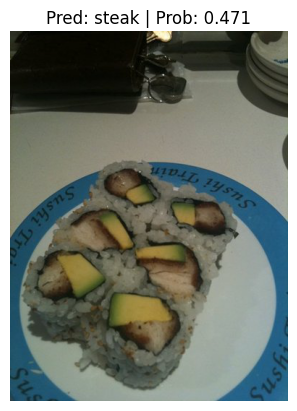

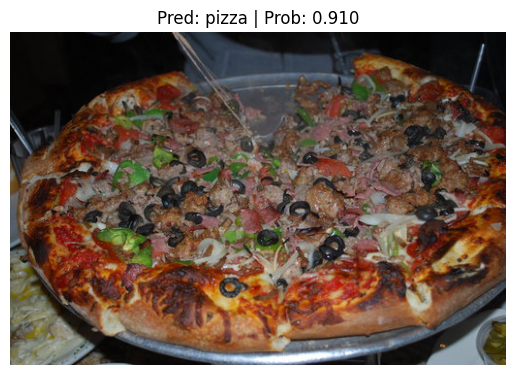

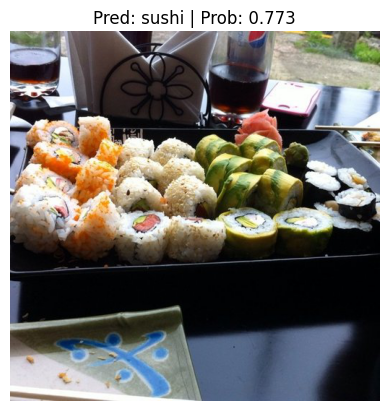

In [50]:
# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path("data/pizza_steak_sushi/test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(
    population = test_image_path_list,
    k = num_images_to_plot # randomly select k number of images
)

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(
        model = model,
        image_path = image_path,
        class_names = class_names,
        image_size = (224, 224)
    )